## 오차 행렬

오차 행렬은 알고리즘의 진짜 음성(True Negative, TN), 거짓 양성(False Positive, FP), 거짓 음성(False Negative, FN), 진짜 양성(True Positive, TP)의 개수를 적은 단순한 정방 행렬이다.</br>

$$\begin{pmatrix} TN & FP \\ FN & TP \end{pmatrix}$$

사이킷런으로 유방암 데이터셋을 SVC로 훈련한 모델에 대한 오차 행렬은 다음과 같다.

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv(   # 위스콘신 유방암 데이터셋 로딩
    'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', 
    header=None
)

x = df.loc[:, 2:].values    # 30개의 특성을 x에 할당
y = df.loc[:, 1].values     # 클래스 레이블을 y에 할당
y = LabelEncoder().fit_transform(y) # 클래스 레이블을 정수로 변환(악성: 1, 양성: 0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify=y, random_state=1)

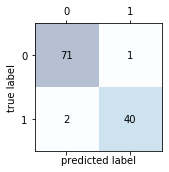

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
pipe_svc.fit(x_train, y_train)
y_pred = pipe_svc.predict(x_test)
# confusion_matrix 함수는 오차 행렬을 만들어준다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

71개의 샘플은 음성으로 올바르게 분류(TN)했다.</br>
40개의 샘플은 악성으로 올바르게 분류(TP)되었다.</br>
2개의 샘플은 음성으로 잘못 분류(FN)되었다.</br>
1개의 샘플은 악성으로 잘못 분류(FP)되었다.</br>

## 분류 모델의 정밀도와 재현율 최적화

이진 분류(binary classification)의 성능 측정 지표로는 다음과 같은 것들이 있다.</br>

- 예측 오차: 전체 샘플에서 잘못 분류된 비율</br>
$$ERR={FP+FN \over FP+FN+TP+TN}$$

- 정확도: 전체 샘플에서 올바르게 분류된 비율</br>
$$ACC={TP+TN \over FP+FN+TP+TN}=1-ERR$$

- 거짓 양성 비율: 전체 음성 샘플 중에서 잘못 분류된 음성 샘플의 비율</br>
$$FPR={FP \over FP+TN}$$

- 재현율(진짜 양성 비율): 전체 양성 샘플 중에서 올바르게 분류된 양성 샘플의 비율</br>
$$REC=TPR={TP \over FN+TP}$$

- 정밀도: 양성으로 분류된 샘플중에서 진짜 양성의 비율</br>
$$PRE={TP \over TP+FP}$$

- F1 점수: PRE와 REC의 조합</br>
$$F1=2{PRE*REC \over PRE+REC}$$

정밀도, 재현율, F1을 사이킷런으로 구하면 다음과 같다. 

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정밀도: 0.976
재현율: 0.952
F1: 0.964


다음은 그리드 서치에 accuracy 대신 다른 성능 지표를 적용한 예이다. 

In [5]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

# 성능 측정 지표로 F1을 사용하고, 양성 레이블을 기존 1에서 0으로 바꾸어 측정한다.
scorer = make_scorer(f1_score, pos_label=0)
c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [  # 튜닝 대상 매개변수의 리스트
    # 선형 SVM은 규제 매개변수 C만 튜닝한다.
    {'svc__C': c_gamma_range, 'svc__kernel': ['linear']},
    # RBF 커널 SVM에서는 C와 gamma 매개변수를 튜닝한다.
    {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}
]

gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring=scorer,     # 성능 측정 지표를 F1으로 변경한다.
    cv=10
)
gs.fit(x_train, y_train)

print(gs.best_score_)   # 최상의 모델 점수
print(gs.best_params_)  # 최상의 모델 점수를 만든 매개변수 값

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## 다중 분류의 성능 지표

다중 분류의 성능 측정 지표로는 다음과 같은 것들이 있다.</br>

- 마이크로(micro) 평균: 클래스별로 TP, TN, FP, FN을 계산</br>
$$PRE_micro={TP_1+...+TP_k \over TP_1+...+TP_,+FP_1+...+FP_k}$$

- 마크로(macro) 평균: 클래스별 정밀도의 평균</br>
$$PRE_macro={PRE_1+...+PRE_k \over k}$$

마이크로 평균은 각 샘플이나 예측에 동일한 가중치를 부여할때 사용한다.</br>

마크로 평균은 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능을 평가할때 사용한다.</br>
일반적으로는 마크로 평균에 가중치를 적용해서 사용한다.</br>
가중치가 적용된 마크로 평균은 클래스 레이블의 샘플 개수를 평규을 계산할때 가중해서 계산한다.</br>
가중치가 저용된 마크로 평균은 레이블마다 샘플 개수가 다른 불균형한 클래스를 다룰때 유용하다.

In [6]:
# 사이킷런은 다중분류 문제일 경우, 자동으로 가중치가 적용된 마크로를 사용한다.
pre_scorer = make_scorer(
    score_func=precision_score,
    pos_label=1,
    greater_is_better=True,
    average='micro'     # 평균 계산 방식을 지정
)